In [75]:
context_size = 8

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random

with open ('D:/Download/names.txt', 'r') as f:
    names = f.read().splitlines()
az = sorted(set(''.join(names)))
stoi = {s:i+1 for i, s in enumerate(az)}
stoi['.'] = 0
vocab_size = len(stoi)
itos = {i:s for s,i in stoi.items()}

random.seed(42)
random.shuffle(names)

def build_set(any_names):
    X, Y = [], []
    for name in any_names:
        context = [0]*context_size
        for chs in name + '.':
            ix = stoi[chs]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X,Y

percent_tr = 0.8
percent_dev = 0.9
to1 = int(percent_tr * len(names))
to2 = int(percent_dev * len(names))
Xtr, Ytr = build_set(names[:to1])
Xdev, Ydev = build_set(names[to1:to2])
Xte, Yte = build_set(names[to2:])

In [77]:
class Linear:
    def __init__(self, fan_in, fan_out, bias = True):
        self.weight = torch.randn(fan_in, fan_out)/fan_in**0.5 # kaiming init
        self.bias = torch.zeros(fan_out) if bias else None
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    def parameters(self):
        return [self.weight] + ([self.bias] if self.bias is not None else [])
        
class Batchnorm1d:
    def __init__(self, fan, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        self.gamma = torch.ones(fan)
        self.beta = torch.zeros(fan)
        self.running_mean = torch.zeros(fan)
        self.running_var = torch.ones(fan)
    def __call__(self, x):
        if self.training:
            if x.ndim == 2:
                nl = 0
            elif x.ndim == 3:
                nl = (0,1)
            xmean = x.mean(nl, keepdim = True)
            xvar = x.var(nl, keepdim = True)
            with torch.no_grad(): # buffers
                self.running_mean = (1-self.momentum)*self.running_mean + self.momentum*xmean
                self.running_var = (1-self.momentum)*self.running_var + self.momentum*xvar
        else:
            xmean = self.running_mean
            xvar = self.running_var
        self.out = self.gamma * (x - xmean)/(xvar+self.eps).sqrt() + self.beta
        return self.out
    def parameters(self):
        return [self.gamma, self.beta]
        
class Tanh:
    def __call__(self, x):
        self.out = x.tanh()
        return self.out
    def parameters(self):
        return []

In [33]:
class Embedding:
    def __init__(self, num, lenght):
        self.weight = torch.randn(num, lenght)
    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out
    def parameters(self):
        return [self.weight]
        
class FlattenConsecutive:
    def __init__(self, n):
        self.n = n
    def __call__(self, x):
        B, T, C = x.shape
        x = x.view(B, T//self.n, C*self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out
    def parameters(self):
        return []
        
class Sequential:
    def __init__(self, layers):
        self.layers = layers
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [80]:
torch.manual_seed(42)
n_embd = 24
n_hidden = 128
max_range = 200000
mini_batch = 32
lr = 0.1
lr_decay = 0.01
consecutive = 2
lossi = []
utod = []

model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(consecutive), Linear(consecutive*n_embd, n_hidden, bias = False), Batchnorm1d(n_hidden), Tanh(),
    FlattenConsecutive(consecutive), Linear(consecutive*n_hidden, n_hidden, bias = False), Batchnorm1d(n_hidden), Tanh(),
    FlattenConsecutive(consecutive), Linear(consecutive*n_hidden, n_hidden, bias = False), Batchnorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
])

with torch.no_grad():
    model.layers[-1].weight *= 0.1
parameters = model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

76579


In [81]:
for i in range (max_range):
    ix = torch.randint(Xtr.shape[0], (mini_batch,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)
    
    for p in parameters:
        p.grad = None
    loss.backward()

    lr = lr if i<150000 else lr_decay
    for p in parameters:
        p.data -= lr * p.grad
        
    with torch.no_grad():
        utod.append([(p.grad.std()*lr/p.data.std()).log10().item() for p in parameters])
    if i % (max_range//10) == 0 or i == max_range-1:
        print(f'{i:7d} / {max_range} | loss = {loss.item():.4f} | lr = {lr}')
    lossi.append(loss.item())
    # break

      0 / 200000 | loss = 3.3167 | lr = 0.1
  20000 / 200000 | loss = 2.0723 | lr = 0.1
  40000 / 200000 | loss = 2.1476 | lr = 0.1
  60000 / 200000 | loss = 2.2592 | lr = 0.1
  80000 / 200000 | loss = 1.6875 | lr = 0.1
 100000 / 200000 | loss = 1.7736 | lr = 0.1
 120000 / 200000 | loss = 1.7465 | lr = 0.1
 140000 / 200000 | loss = 1.7406 | lr = 0.1
 160000 / 200000 | loss = 1.8805 | lr = 0.01
 180000 / 200000 | loss = 1.6476 | lr = 0.01
 199999 / 200000 | loss = 1.8919 | lr = 0.01


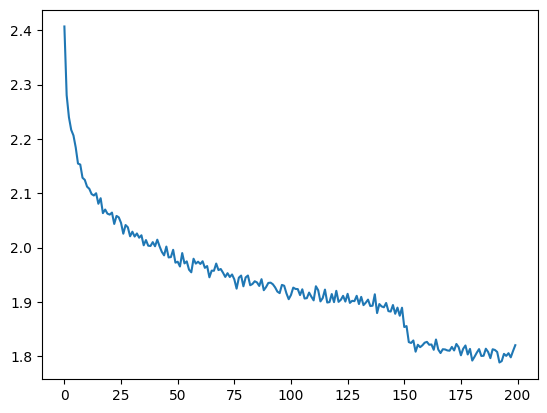

In [83]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1));

 0 |   (27, 24) | -0.000 mean | 1.221318e-02 std | ratio update/data: 1.130238e-04
 1 |  (48, 128) | -0.000 mean | 7.511314e-03 std | ratio update/data: 2.133862e-04
 2 |     (128,) | +0.001 mean | 4.948274e-03 std | ratio update/data: 3.565884e-04
 3 |     (128,) | +0.001 mean | 1.032268e-02 std | ratio update/data: 2.720740e-04
 4 | (256, 128) | -0.000 mean | 4.998834e-03 std | ratio update/data: 2.317192e-04
 5 |     (128,) | -0.000 mean | 4.230694e-03 std | ratio update/data: 2.914033e-04
 6 |     (128,) | -0.000 mean | 9.116137e-03 std | ratio update/data: 2.367366e-04
 7 | (256, 128) | +0.000 mean | 4.720244e-03 std | ratio update/data: 2.401592e-04
 8 |     (128,) | -0.001 mean | 7.760798e-03 std | ratio update/data: 1.514902e-04
 9 |     (128,) | +0.000 mean | 1.546883e-02 std | ratio update/data: 5.311683e-04
10 |  (128, 27) | +0.000 mean | 1.962652e-02 std | ratio update/data: 7.822872e-04
11 |      (27,) | +0.000 mean | 2.183454e-02 std | ratio update/data: 2.147308e-04


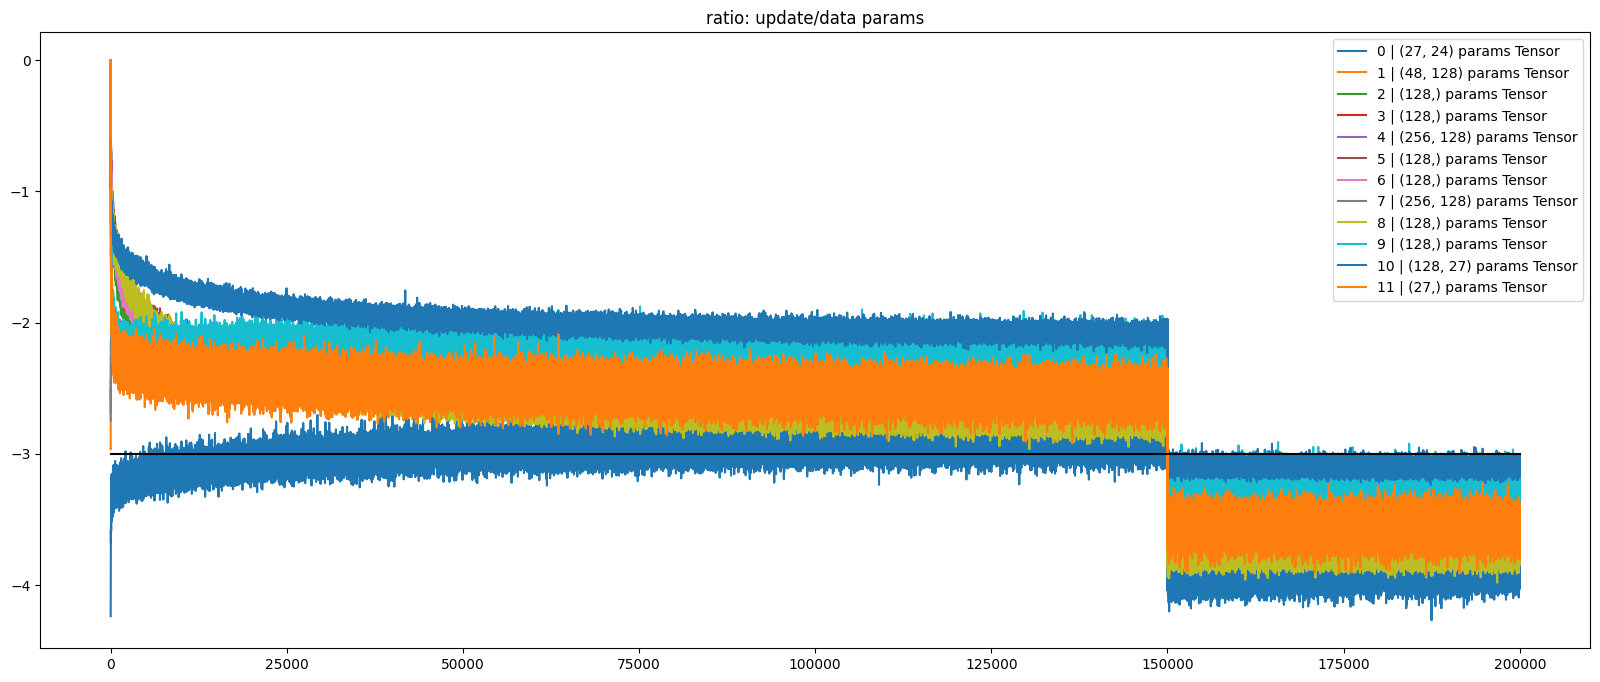

In [84]:
with torch.no_grad():
    plt.figure(figsize=(20,8))
    legends = []
    for i,p in enumerate(parameters):
        if p.ndim == 2 or 1:
            plt.plot([utod[j][i] for j in range(len(utod))])
            print ('%2d | %10s | %+.3f mean | %e std | ratio update/data: %e' % (i, tuple(p.shape), p.grad.mean(), p.grad.std(), lr*p.grad.std()/p.data.std()))
            legends.append(f'{i} | {tuple(p.shape)} params {p.__class__.__name__}')
    plt.plot([0, len(utod)], [-3,-3], 'k')
    plt.legend(legends)
    plt.title('ratio: update/data params');

In [85]:
for layer in model.layers:
    layer.training = False
@torch.no_grad()
def evaluate(any_str):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[any_str]
    logits = model(x)
    loss = F.cross_entropy (logits, y)
    print(any_str, loss.item())
evaluate('train')
evaluate('val')

train 1.7690287828445435
val 1.993652105331421


In [86]:
with torch.no_grad():
    for k in range(20):
        out = []
        context = context_size * [0]
        while True:
            logits = model(torch.tensor([context]))
            probs = F.softmax(logits, 1)
            next_ix = torch.multinomial(probs, 1).item()
            context = context[1:] + [next_ix]
            out.append(itos[next_ix])
            if next_ix == 0:
                break
        print (''.join(out))

arlij.
chetta.
heago.
rocklei.
hendrix.
jamylie.
broxin.
denish.
anslibt.
marianah.
astavia.
annayve.
aniah.
jayce.
nodiel.
remita.
niyelle.
jaylene.
aiyan.
aubreana.
